## Importação de dependências

In [ ]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

## Coleta de dados

In [ ]:
symbol = 'TSLA'
start_date = '2015-01-01'
end_date = '2024-07-01'

df = yf.download(symbol, start=start_date, end=end_date)
df = df[['Open', 'Close']]
df.head()

[*********************100%***********************]  1 of 1 completed


Price            Open      Close
Ticker           TSLA       TSLA
Date                            
2015-01-02  14.858000  14.620667
2015-01-05  14.303333  14.006000
2015-01-06  14.004000  14.085333
2015-01-07  14.223333  14.063333
2015-01-08  14.187333  14.041333

## Pré-processamento

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

# Função para criar janelas temporais
def create_sequences(data, time_steps=30):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps, 0])
        y.append(data[i+time_steps, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(df_scaled)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

## Criação e treinamento do modelo

In [ ]:
# Estrutura do modelo
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinamento
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50
48/48 [==============================] - 10s 58ms/step - loss: 0.0137 - val_loss: 0.0015
Epoch 2/50
48/48 [==============================] - 1s 16ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 3/50
48/48 [==============================] - 1s 17ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 4/50
48/48 [==============================] - 1s 15ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 5/50
48/48 [==============================] - 1s 15ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 6/50
48/48 [==============================] - 1s 20ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 7/50
48/48 [==============================] - 1s 16ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 8/50
48/48 [==============================] - 1s 15ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 9/50
48/48 [==============================] - 1s 18ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 10/50
48/48 [==============================] - 1s 15ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 11

## Resultados

In [ ]:
# Avaliação
model.evaluate(X_test, y_test)

15/15 [==============================] - 0s 7ms/step - loss: 0.0012


0.001220526173710823

In [ ]:
# Predições
y_pred = model.predict(X_test)

In [55]:
y_test_rescaled = scaler.inverse_transform(np.column_stack((np.zeros_like(y_test), y_test)))[:, 1]
y_pred_rescaled = scaler.inverse_transform(np.column_stack((np.zeros_like(y_pred), y_pred)))[:, 1]

mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(root_mean_squared_error(y_test_rescaled, y_pred_rescaled))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Error (MAE): 7.51
Root Mean Squared Error (RMSE): 3.74


In [53]:
mse = root_mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test,y_pred)
print(f'MSE: {mse}\nRMSE: {rmse}\nMAPE: {mape}')

MSE: 0.03493603220626052
RMSE: 0.1869118300329343
MAPE: 38368497733.547386


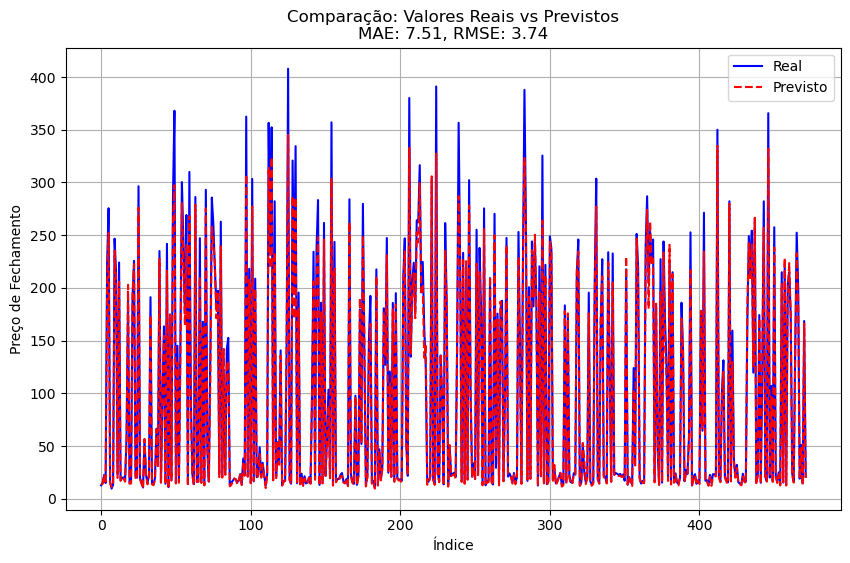

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label="Real", color='blue')
plt.plot(y_pred_rescaled, label="Previsto", color='red', linestyle='dashed')
plt.title(f'Comparação: Valores Reais vs Previstos\nMAE: {mae:.2f}, RMSE: {rmse:.2f}')
plt.xlabel('Índice')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True)
plt.show()

## Serialização do artefato de modelo

In [ ]:
model.save("stock_price_predictor.h5")
joblib.dump(scaler, 'scaler.pkl')